In [1]:
%config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

from src.echonet_dataset import EchoNetDynamicDataset
from src.utils.echo_utils import get2dPucks
from src.utils.camus_validate import cleanupSegmentation
from src.utils.torch_utils import TransformDataset, torch_collate
from src.utils.echo_utils import makeVideo
from src.visualization_utils import echonet_overlay
from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import torch.nn.functional as F
import torch
import torch.nn as nn
from torchvision.models.video import r2plus1d_18

from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from scipy.signal import find_peaks

import random
import pickle
import time

In [2]:
batch_size = 4
num_workers = max(4, cpu_count()//2)

def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}

In [3]:
with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

full_dataset = EchoNetDynamicDataset(split='val', clip_length="full", subset_indices=valid_mask, period=1)
test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)

100%|██████████| 16/16 [00:01<00:00, 14.09it/s]


In [4]:
def divide_to_consecutive_clips(video, clip_length=32, interpolate_last=False):
    source_video = video.copy()
    video_length = video.shape[1]
    left = video_length % clip_length
    if left != 0 and interpolate_last:
        source_video = torch.Tensor(source_video).unsqueeze(0)
        source_video = F.interpolate(source_video, size=(int(np.round(video_length / clip_length) * clip_length), 112, 112),
                                     mode="trilinear", align_corners=False)
        source_video = source_video.squeeze(0).squeeze(0)
        source_video = source_video.numpy()
    
    videos = np.empty(shape=(1, 3, clip_length, 112, 112))

    for start in range(0, int(clip_length * np.round(video_length / clip_length)), clip_length):
        one_clip = source_video[:, start: start + clip_length]
        one_clip = np.expand_dims(one_clip, 0)
        videos = np.concatenate([videos, one_clip])
    return videos[1:]


def get_all_possible_start_points(ed_index, es_index, video_length, clip_length):
    assert es_index - ed_index > 0, "not a ED to ES clip pair"
    possible_shift = clip_length - (es_index - ed_index)
    allowed_right = video_length - es_index
    if allowed_right < possible_shift:
        return np.arange(ed_index - possible_shift + 1, video_length - clip_length + 1)
    if possible_shift < 0:
        return np.array([ed_index])
    elif ed_index < possible_shift:
        return np.arange(ed_index + 1)
    else:
        return np.arange(ed_index - possible_shift + 1, ed_index + 1)

In [5]:
model_save_path = "save_models/R2plus1DMotionSegNet_model_tmp.pth"

model = torch.nn.DataParallel(R2plus1D_18_MotionNet())
model.to("cuda")
torch.cuda.empty_cache()
model.load_state_dict(torch.load(model_save_path)["model"])
print(f'R2+1D MotionNet has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')

model.eval();

R2+1D MotionNet has 31575731 parameters.


In [6]:
test_pat_index = np.random.randint(len(test_dataset))
# test_pat_index = 1089


video, (filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label) = test_dataset[test_pat_index]

interpolate_last = True
all_consecutive_clips = []

step = 1
num_clips = 5

for shift_dis in range(0, num_clips * step, step):
    shifted_video = video[:, shift_dis:]
    consecutive_clips = divide_to_consecutive_clips(shifted_video, interpolate_last=interpolate_last)
    all_consecutive_clips.append(consecutive_clips)
    
all_consecutive_clips = np.array(all_consecutive_clips)
all_consecutive_clips.shape

(5, 4, 3, 32, 112, 112)

### Segment the Consecutive 32-Frame video clips
If the video length is not a multiple of 32 (32-frame video clips), then interpolate the video so its length equals to the nearest multiple of 32.

For example, a video with length 88 will be interpolated to 96, and a video with length 72 will be interpolated to 64.

In [7]:
all_segmentations = []
all_motions = []

for i in range(len(all_consecutive_clips)):
    consecutive_clips = all_consecutive_clips[i]
    segmentation_outputs = np.empty(shape=(1, 2, 32, 112, 112))
    motion_outputs = np.empty(shape=(1, 4, 32, 112, 112))

    for i in range(consecutive_clips.shape[0]):
        one_clip = np.expand_dims(consecutive_clips[i], 0)
        segmentation_output, motion_output = model(torch.Tensor(one_clip))
        segmentation_output = F.softmax(segmentation_output, 1)
        segmentation_outputs = np.concatenate([segmentation_outputs, segmentation_output.cpu().detach().numpy()])
        motion_outputs = np.concatenate([motion_outputs, motion_output.cpu().detach().numpy()])
    segmentation_outputs = segmentation_outputs[1:]
    motion_outputs = motion_outputs[1:]
    
    all_segmentations.append(segmentation_outputs)
    all_motions.append(motion_outputs)

all_segmentations = all_segmentations
all_motions = np.array(all_motions)
    
display(np.array(all_segmentations).shape)
all_motions.shape

(5, 4, 2, 32, 112, 112)

(5, 4, 4, 32, 112, 112)

### Interpolate the softmax output

In [8]:
for i in range(len(all_segmentations)):
    all_segmentations[i] = all_segmentations[i].transpose([1, 0, 2, 3, 4])
    all_segmentations[i] = all_segmentations[i].reshape(2, -1, 112, 112)

all_interpolated_segmentations = []

for i in range(0, len(all_consecutive_clips)):
    video_clip = video[:, i:]
    if interpolate_last and (video_clip.shape[1] % 32 != 0):
        one_segmentation = all_segmentations[i]
        one_segmentation = torch.Tensor(one_segmentation).unsqueeze(0)
        one_segmentation = F.interpolate(one_segmentation, size=(video.shape[1] - i, 112, 112), 
                                         mode="trilinear", align_corners=False)
        one_segmentation = one_segmentation.squeeze(0).numpy()
        print(one_segmentation.shape)
        all_interpolated_segmentations.append(np.argmax(one_segmentation, 0))
    else:
        print(all_segmentations[i].shape)
        all_interpolated_segmentations.append(np.argmax(all_segmentations[i], 0))

(2, 122, 112, 112)
(2, 121, 112, 112)
(2, 120, 112, 112)
(2, 119, 112, 112)
(2, 118, 112, 112)


### Plot the Segmented LV Sizes from the Consecutive Clips

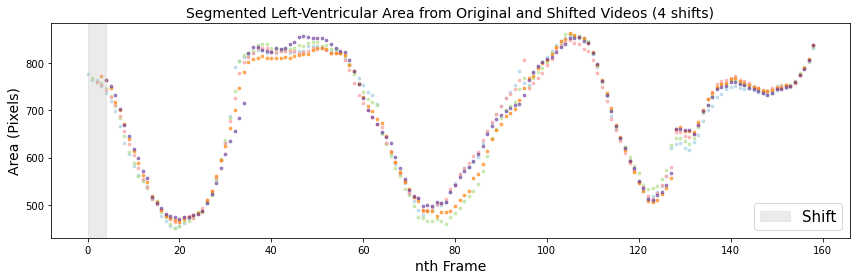

In [325]:
fig, ax = plt.subplots(1, figsize=(12, 4))

for i in range(0, len(all_interpolated_segmentations)):
    lv_sizes = np.sum(all_interpolated_segmentations[i], axis=(1, 2)).ravel()

    color = cm.Paired(i / 5)
    ax.scatter(np.arange(0 + i * step, len(lv_sizes) + i * step), lv_sizes, color=color, alpha=0.6, s=30, marker='.')


ax.set_title("Segmented Left-Ventricular Area from Original and Shifted Videos ({:d} shifts)"
             .format(len(all_interpolated_segmentations) - 1), 
             fontsize=14)
ax.set_xlabel("nth Frame", fontsize=14)
ax.set_ylabel("Area (Pixels)", fontsize=14)


for i in range(0, 31, 32):
    if i == 0:
        ax.axvspan(i, i + 4, alpha=0.3, color='silver', label="Shift")

plt.legend(fontsize=15, ncol=1, loc="lower right")
plt.tight_layout()

plt.show()

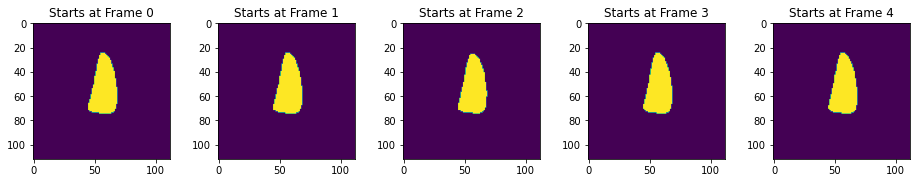

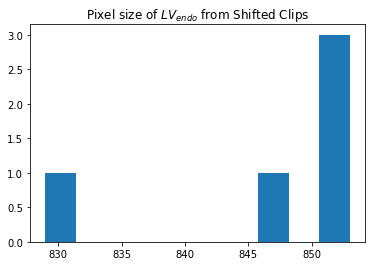

In [326]:
fig, ax = plt.subplots(len(all_interpolated_segmentations) // 5, 5, 
                       figsize=(13, 2.5 * (len(all_interpolated_segmentations) // 5)))
lv_sizes_at_a_point = []

index_pos = ed_index

for i in range(len(all_interpolated_segmentations) // 5):
    for j in range(5):
        if len(all_interpolated_segmentations) // 5 == 1:
            ax[j].set_title("Starts at Frame{:2d}".format((i * 5 + j) * step))
            ax[j].imshow(all_interpolated_segmentations[i * 5 + j][index_pos - (i * 5 + j) * step])
        else:
            ax[i][j].set_title("Starts at Frame{:2d}".format((i * 5 + j) * step))
            ax[i][j].imshow(all_interpolated_segmentations[i * 5 + j][index_pos - (i * 5 + j) * step])
        lv_sizes_at_a_point.append(np.sum(all_interpolated_segmentations[i * 5 + j][index_pos - (i * 5 + j) * step]))
        
plt.tight_layout()
plt.show()

plt.figure()
plt.title(r"Pixel size of $LV_{endo}$ from Shifted Clips")
plt.hist(lv_sizes_at_a_point)
plt.show()

In [327]:
index_pos = ed_index

images_to_fuse = []
for i in range(0, len(all_interpolated_segmentations)):
    print("Add segmentations{:3d}".format(i))
    images_to_fuse.append(itk.GetImageFromArray(all_interpolated_segmentations[i][index_pos - i * step].astype("uint8"), isVector=False))
fused_staple = fuse_images(images_to_fuse, 'staple') # class_list is not needed for staple/itkvoting
image_staple = itk.GetArrayFromImage(fused_staple)
fused_simple = fuse_images(images_to_fuse, 'simple', class_list=[0,1])
image_simple = np.round(itk.GetArrayFromImage(fused_simple)).astype("uint8")

Add segmentations  0
Add segmentations  1
Add segmentations  2
Add segmentations  3
Add segmentations  4


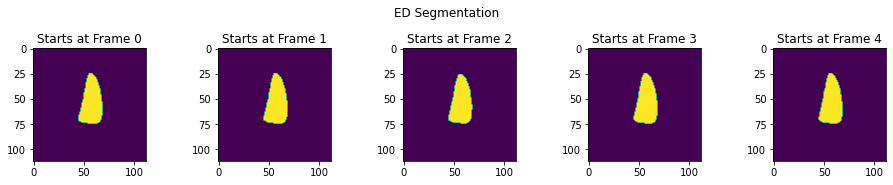

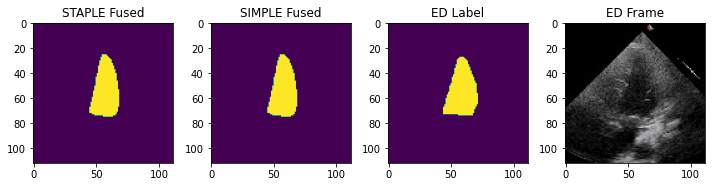

STAPLE LV pixel size: 848
SIMPLE LV pixel size: 848
Mannual LV pixel size: 890.0


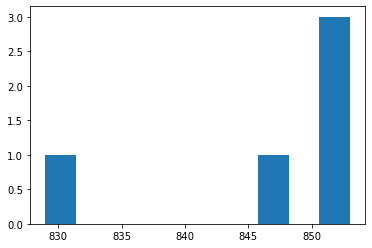

In [328]:
fig, ax = plt.subplots(len(all_interpolated_segmentations) // 5, 5, 
                       figsize=(13, 2.5 * (len(all_interpolated_segmentations) // 5)))
lv_sizes_at_a_point = []

fig.suptitle("ED Segmentation")
for i in range(len(all_interpolated_segmentations) // 5):
    for j in range(5):
        if len(all_interpolated_segmentations) // 5 == 1:
            ax[j].set_title("Starts at Frame{:2d}".format((i * 5 + j) * step))
            ax[j].imshow(all_interpolated_segmentations[i * 5 + j][index_pos - (i * 5 + j) * step])
        else:
            ax[i][j].set_title("Starts at Frame{:2d}".format((i * 5 + j) * step))
            ax[i][j].imshow(all_interpolated_segmentations[i * 5 + j][index_pos - (i * 5 + j) * step])
        lv_sizes_at_a_point.append(np.sum(all_interpolated_segmentations[i * 5 + j][index_pos - (i * 5 + j) * step]))
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 4, figsize=(10, 2.5))

ax[0].set_title("STAPLE Fused")
ax[0].imshow(image_staple)

ax[1].set_title("SIMPLE Fused")
ax[1].imshow(image_simple)

ax[2].set_title("ED Label")
ax[2].imshow(ed_label)

ax[3].set_title("ED Frame")
ax[3].imshow(ed_frame.transpose([1, 2, 0]))

plt.tight_layout()

plt.show()

print("STAPLE LV pixel size:", np.sum(image_staple))
print("SIMPLE LV pixel size:", np.sum(image_simple))
print("Mannual LV pixel size:", np.sum(ed_label))

plt.figure()
plt.hist(lv_sizes_at_a_point)
plt.show()

In [329]:
index_pos = es_index

images_to_fuse = []
for i in range(0, len(all_interpolated_segmentations)):
    print("Add segmentations{:3d}".format(i))
    images_to_fuse.append(itk.GetImageFromArray(all_interpolated_segmentations[i][index_pos - i * step].astype("uint8"), isVector=False))
fused_staple = fuse_images(images_to_fuse, 'staple') # class_list is not needed for staple/itkvoting
# sitk.WriteImage(fused_staple, '/path/to/output_staple.nii.gz')
image_staple = itk.GetArrayFromImage(fused_staple)
fused_simple = fuse_images(images_to_fuse, 'simple', class_list=[0,1])
# sitk.WriteImage(fused_simple, '/path/to/output_simple.nii.gz')
image_simple = np.round(itk.GetArrayFromImage(fused_simple)).astype("uint8")
# image_simple = itk.GetArrayFromImage(fused_simple)

Add segmentations  0
Add segmentations  1
Add segmentations  2
Add segmentations  3
Add segmentations  4


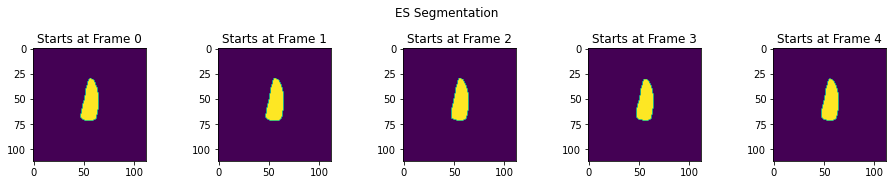

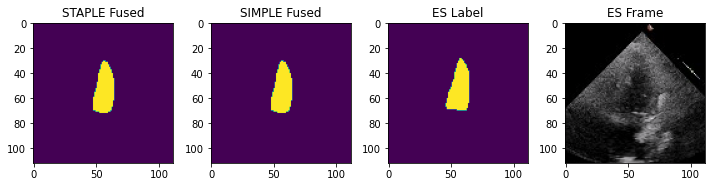

STAPLE LV pixel size: 533
SIMPLE LV pixel size: 533
Mannual LV pixel size: 545.0


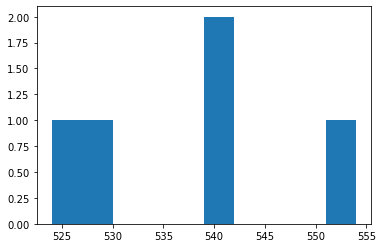

In [330]:
fig, ax = plt.subplots(len(all_interpolated_segmentations) // 5, 5, 
                       figsize=(13, 2.5 * (len(all_interpolated_segmentations) // 5)))
lv_sizes_at_a_point = []


fig.suptitle("ES Segmentation")
for i in range(len(all_interpolated_segmentations) // 5):
    for j in range(5):
        if len(all_interpolated_segmentations) // 5 == 1:
            ax[j].set_title("Starts at Frame{:2d}".format((i * 5 + j) * step))
            ax[j].imshow(all_interpolated_segmentations[i * 5 + j][index_pos - (i * 5 + j) * step])
        else:
#         ax[i][j].imshow(all_interpolated_segmentations[i * 5 + j][ed_index - i * 5 - j])
            ax[i][j].set_title("Starts at Frame{:2d}".format((i * 5 + j) * step))
            ax[i][j].imshow(all_interpolated_segmentations[i * 5 + j][index_pos - (i * 5 + j) * step])
        lv_sizes_at_a_point.append(np.sum(all_interpolated_segmentations[i * 5 + j][index_pos - (i * 5 + j) * step]))
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 4, figsize=(10, 2.5))

ax[0].set_title("STAPLE Fused")
ax[0].imshow(image_staple)

ax[1].set_title("SIMPLE Fused")
ax[1].imshow(image_simple)

ax[2].set_title("ES Label")
ax[2].imshow(es_label)

ax[3].set_title("ES Frame")
ax[3].imshow(es_frame.transpose([1, 2, 0]))

plt.tight_layout()
plt.show()

print("STAPLE LV pixel size:", np.sum(image_staple))
print("SIMPLE LV pixel size:", np.sum(image_simple))
print("Mannual LV pixel size:", np.sum(es_label))

plt.figure()
plt.hist(lv_sizes_at_a_point)
plt.show()

### Fuse the Labels if there more than one Label available

In [9]:
fused_segmentations = [all_interpolated_segmentations[0][0]]
fuse_method = "simple"
# class_list = None
class_list = [0, 1]

for i in range(0, video.shape[1]):
    if step - 1 < i:
        images_to_fuse = []
        for index in range(min(i, len(all_interpolated_segmentations))):
            if i - index * step < 0:
                break
            images_to_fuse.append(itk.GetImageFromArray(all_interpolated_segmentations[index][i - index * step].astype("uint8"),
                                                        isVector=False))
        if len(images_to_fuse) <= 1:
            fused_segmentations.append(itk.GetArrayFromImage(images_to_fuse[0]))
        else:
            fused_image = fuse_images(images_to_fuse, fuse_method, class_list=class_list)
            # If using SIMPLE, the fused image is in type "float"
            # So convert it to uint
            fused_segmentations.append(itk.GetArrayFromImage(fused_image).astype("uint8"))
            
fused_segmentations = np.array(fused_segmentations)
fused_segmentations.shape

(122, 112, 112)

### Plot the LV pixel size of fused labels

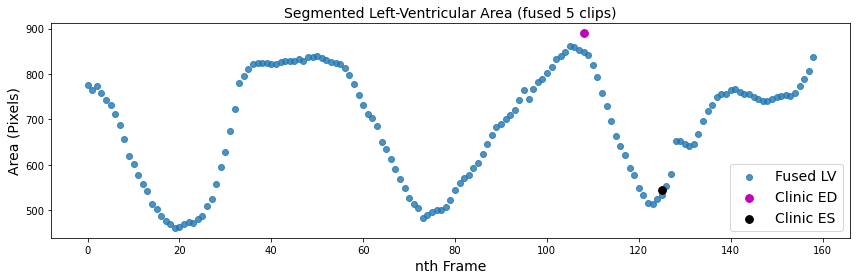

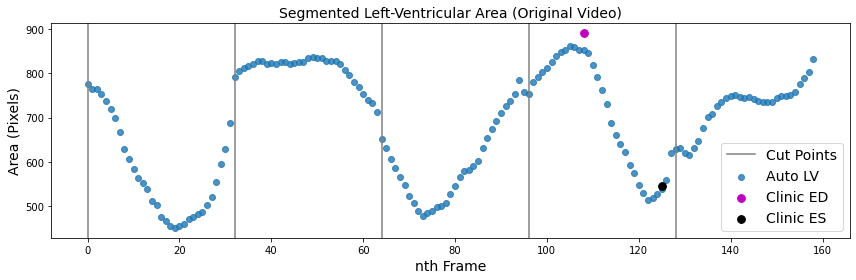

In [332]:
fig, ax = plt.subplots(1, figsize=(12, 4))

lv_sizes = np.sum(fused_segmentations, axis=(1, 2)).ravel()

ax.scatter(np.arange(len(lv_sizes)), lv_sizes, alpha=0.8, label="Fused LV")

ax.set_title("Segmented Left-Ventricular Area (fused {:d} clips)".format(len(all_interpolated_segmentations)), fontsize=14)
ax.set_xlabel("nth Frame", fontsize=14)
ax.set_ylabel("Area (Pixels)", fontsize=14)

plt.scatter(ed_index, np.sum(ed_label), 
            s=60, color="m", label="Clinic ED")
plt.scatter(es_index, np.sum(es_label), 
            s=60, color="k", label="Clinic ES")

plt.legend(fontsize=14, ncol=1, loc="lower right")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, figsize=(12, 4))

lv_sizes = np.sum(all_interpolated_segmentations[0], axis=(1, 2)).ravel()

ax.scatter(np.arange(len(lv_sizes)), lv_sizes, alpha=0.8, label="Auto LV")

ax.set_title("Segmented Left-Ventricular Area (Original Video)", fontsize=14)
ax.set_ylabel("Area (Pixels)", fontsize=14)
ax.set_xlabel("nth Frame", fontsize=14)

plt.scatter(ed_index, np.sum(ed_label), 
            s=60, color="m", label="Clinic ED")
plt.scatter(es_index, np.sum(es_label), 
            s=60, color="k", label="Clinic ES")

for i in range(0, len(lv_sizes), 32):
    if i == 0:
        ax.axvline(i, 0, 1, c='gray', label="Cut Points")
    else:
        ax.axvline(i, 0, 1, c='gray')

plt.legend(fontsize=14, ncol=1, loc="lower right")
plt.tight_layout()

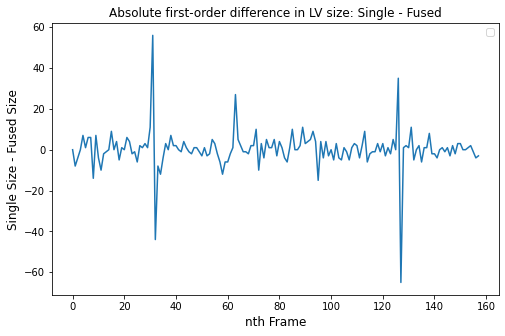

In [333]:
single_lv_sizes = np.sum(all_interpolated_segmentations[0], axis=(1, 2)).ravel()
fused_lv_sizes = np.sum(fused_segmentations, axis=(1, 2)).ravel()

plt.figure(figsize=(8, 5))
plt.title("Absolute first-order difference in LV size: Single - Fused")
plt.ylabel("Single Size - Fused Size", fontsize=12)
plt.xlabel("nth Frame", fontsize=12)
plt.plot(abs(np.diff(single_lv_sizes)) - abs(np.diff(fused_lv_sizes)))
plt.legend()
plt.show()

In [334]:
index_pos = np.argmax(abs(np.diff(single_lv_sizes)) - abs(np.diff(fused_lv_sizes)))

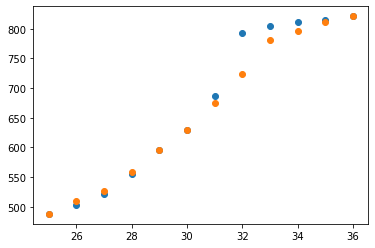

In [335]:
plt.scatter(np.arange(index_pos - 6, index_pos + 6), single_lv_sizes[index_pos - 6: index_pos + 6])
plt.scatter(np.arange(index_pos - 6, index_pos + 6), fused_lv_sizes[index_pos - 6: index_pos + 6])

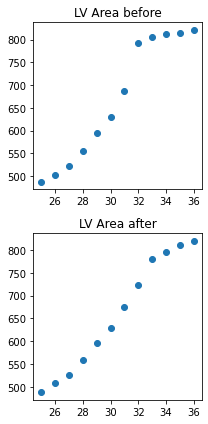

In [336]:
from matplotlib.ticker import MaxNLocator
fig, ax = plt.subplots(2, 1, figsize=(3, 6))

ax[0].set_title("LV Area before")
# ax[0].set_yticklabels([])
ax[0].scatter(np.arange(index_pos - 6, index_pos + 6), single_lv_sizes[index_pos - 6: index_pos + 6])
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ylim = ax[0].get_ylim()

ax[1].set_title("LV Area after")
# ax[1].set_yticklabels([])
ax[1].scatter(np.arange(index_pos - 6, index_pos + 6), fused_lv_sizes[index_pos - 6: index_pos + 6])
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set_ylim(ylim)
plt.tight_layout()

# plt.savefig("lv_area_before_after_patient{:04d}.png".format(test_pat_index),
#             facecolor=(1.0, 1.0, 1.0, 1.0), dpi=300, bbox_inches='tight')

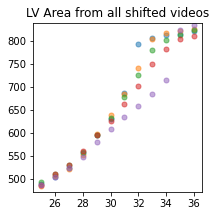

In [337]:
from matplotlib.ticker import MaxNLocator
fig, ax = plt.subplots(1, 1, figsize=(3, 3.1))
for i in range(0, len(all_interpolated_segmentations)):
    lv_sizes = np.sum(all_interpolated_segmentations[i], axis=(1, 2)).ravel()

    ax.set_title("LV Area from all shifted videos")
    ax.scatter(np.arange(index_pos - 6, index_pos + 6), lv_sizes[index_pos - 6 - i * step: index_pos + 6 - i * step], 
               alpha=0.55, s=25, )
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim(ylim)
plt.tight_layout()

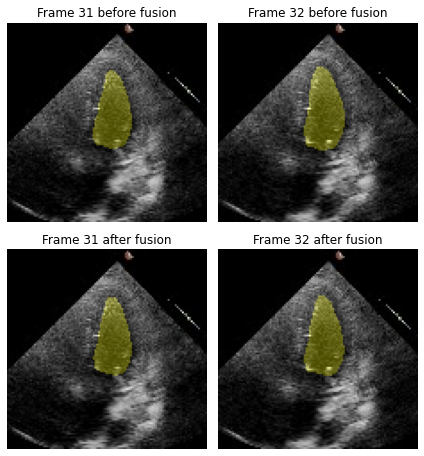

In [338]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6.5))

next_frame_pos = index_pos + 1

before_fused_cur = echonet_overlay(video[:, index_pos].transpose([1, 2, 0]), 
                                                   all_interpolated_segmentations[0][index_pos], 
                                                   vis=False,)
before_fused_next = echonet_overlay(video[:, next_frame_pos].transpose([1, 2, 0]), 
                                    all_interpolated_segmentations[0][next_frame_pos], 
                                    vis=False,)

after_fused_cur = echonet_overlay(video[:, index_pos].transpose([1, 2, 0]), 
                                  fused_segmentations[index_pos], 
                                  vis=False,)
after_fused_next = echonet_overlay(video[:, next_frame_pos].transpose([1, 2, 0]), 
                                   fused_segmentations[next_frame_pos], 
                                   vis=False,)

ax[0][0].set_title("Frame {:d} before fusion".format(index_pos))
ax[0][0].imshow(before_fused_cur)
ax[0][0].axis("off")

ax[0][1].set_title("Frame {:d} before fusion".format(next_frame_pos))
ax[0][1].imshow(before_fused_next)
ax[0][1].axis("off")

ax[1][0].set_title("Frame {:d} after fusion".format(index_pos))
ax[1][0].imshow(after_fused_cur)
ax[1][0].axis("off")

ax[1][1].set_title("Frame {:d} after fusion".format(next_frame_pos))
ax[1][1].imshow(after_fused_next)
ax[1][1].axis("off")

plt.tight_layout()

### Plot the Simpson-method Derived Volume instead of Pixel Sizes

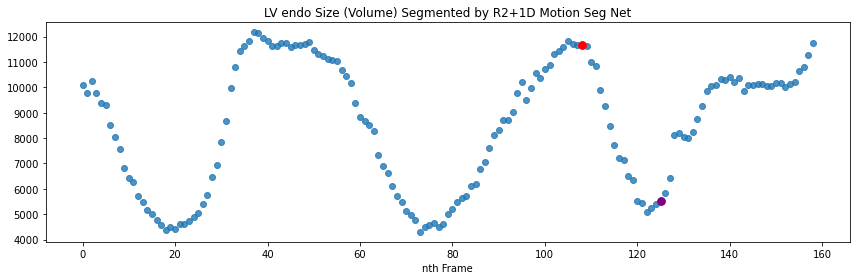

In [339]:
from src.utils.echo_utils import computeSimpsonVolume

fig, ax = plt.subplots(1, figsize=(12, 4))

# plot_clips(test_pat_index, motionSetDataset, ax=ax)

lv_volume = []

for i in range(len(fused_segmentations)):
    output_seg = fused_segmentations[i]

#     lv_length, lv_radius = get2dPucks((output_seg == 1).astype('int'), (1.0, 1.0))
#     volume = np.sum(((np.pi * (lv_radius ** 2)) * lv_length / len(lv_radius)))
    volume = computeSimpsonVolume(output_seg, output_seg, (1.0, 1.0), (1.0, 1.0))

    lv_volume.append(volume)
    
ax.scatter(np.arange(len(lv_volume)), lv_volume, alpha=0.8)

ax.scatter(ed_index, lv_volume[ed_index],
            color="red", s=60, label="Auto ED")

ax.scatter(es_index, lv_volume[es_index],
            color="purple", s=60, label="Auto ES")

ax.set_title("LV endo Size (Volume) Segmented by R2+1D Motion Seg Net")
ax.set_xlabel("nth Frame")

plt.tight_layout()
plt.show()

### Compute the Ejection Fraction

#### 1. Find the ED to ES video clips

In [340]:
# from queue import SimpleQueue as squeue

def EDESpairs(diastole, systole):
    dframes = np.sort(np.array(diastole))
    sframes = np.sort(np.array(systole))
    clips = []
    
    inds = np.searchsorted(dframes, sframes, side='left')
    for i, sf in enumerate(sframes):
        if inds[i] == 0: # no prior diastolic frames for this sf
            continue
        best_df = diastole[inds[i]-1] # diastole frame nearest this sf.
        if len(clips) == 0 or best_df != clips[-1][0]:
            clips.append((best_df, sf))
            
    return clips

#### Determine the ED to ES clip pairs using LV sizes

In [341]:
size = np.sum(fused_segmentations, axis=(1, 2)).ravel()
# _85cut = 65 for patient 801
_05cut, _85cut, _95cut = np.percentile(size, [5, 85, 95]) 

trim_min = _05cut
trim_max = _95cut
trim_range = trim_max - trim_min
systole = find_peaks(-size, distance=20, prominence=(0.50 * trim_range))[0]
diastole = find_peaks(size, distance=20, prominence=(0.50 * trim_range))[0]

# keep only real diastoles..
diastole = [x for x in diastole if size[x] >= _85cut]
# Add first frame
if np.mean(size[:3]) >= _85cut:
    diastole = [0] + diastole
diastole = np.array(diastole)

clip_pairs = EDESpairs(diastole, systole)

In [342]:
print("Found {:d} ED-ES clips".format(len(clip_pairs)))
clip_pairs

Found 2 ED-ES clips


[(50, 73), (105, 123)]

#### 2. Plot the position of identified Clip

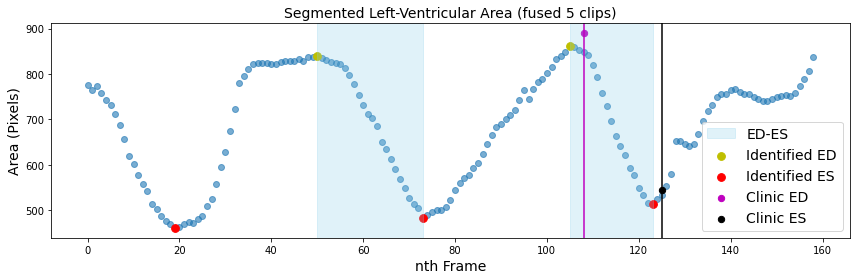

In [343]:
fig, ax = plt.subplots(1, figsize=(12, 4))

first = True

for clip in clip_pairs:
    if first:
        ax.axvspan(clip[0], clip[1], alpha=0.25, color='skyblue', label="ED-ES")
        first=False
    else:
        ax.axvspan(clip[0], clip[1], alpha=0.25, color='skyblue')

ax.scatter(np.arange(len(size)), size, alpha=.6)
        
ax.scatter(diastole, size[diastole], s=60, c='y', label="Identified ED")
ax.scatter(systole, size[systole], s=60, c='r', label="Identified ES")

ax.scatter([ed_index], np.sum(ed_label==1), s=40, c='m', label="Clinic ED")
ax.scatter([es_index], np.sum(es_label==1), s=40, c='k', label="Clinic ES")

ax.axvline(es_index, c='k')
ax.axvline(ed_index, c='m')

ax.set_title("Segmented Left-Ventricular Area (fused {:d} clips)".format(len(all_interpolated_segmentations)), 
                fontsize=14)
ax.set_xlabel("nth Frame", fontsize=14)
ax.set_ylabel("Area (Pixels)", fontsize=14)
ax.legend(fontsize=14, loc='lower right')
plt.tight_layout()

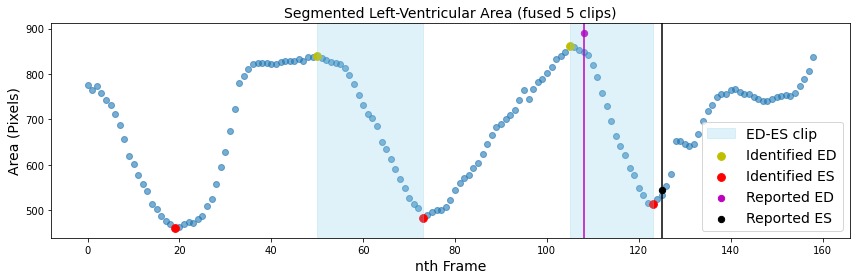

In [344]:
fig, ax = plt.subplots(1, figsize=(12, 4))

first = True

for clip in clip_pairs:
    if first:
        ax.axvspan(clip[0], clip[1], alpha=0.25, color='skyblue', label="ED-ES clip")
        first=False
    else:
        ax.axvspan(clip[0], clip[1], alpha=0.25, color='skyblue')

ax.scatter(np.arange(len(size)), size, alpha=.6)
        
ax.scatter(diastole, size[diastole], s=60, c='y', label="Identified ED")
ax.scatter(systole, size[systole], s=60, c='r', label="Identified ES")

ax.scatter([ed_index], np.sum(ed_label==1), s=40, c='m', label="Reported ED")
ax.scatter([es_index], np.sum(es_label==1), s=40, c='k', label="Reported ES")

ax.axvline(es_index, c='k')
ax.axvline(ed_index, c='m')

ax.set_title("Segmented Left-Ventricular Area (fused {:d} clips)".format(len(all_interpolated_segmentations)), 
                fontsize=14)
ax.set_xlabel("nth Frame", fontsize=14)
ax.set_ylabel("Area (Pixels)", fontsize=14)
ax.legend(fontsize=14, loc='lower right')

plt.tight_layout()
plt.show()

#### 3. Compute the Ejection using ED and ES segmentation in determined ED to ES clips

In [345]:
one_array_of_segmentations = fused_segmentations.reshape(-1, 112, 112)

predicted_efs = []

for i in range(len(clip_pairs)):
    output_ED = one_array_of_segmentations[clip_pairs[i][0]]
    output_ES = one_array_of_segmentations[clip_pairs[i][1]]

    length_ed, radius_ed = get2dPucks(cleanupSegmentation(output_ED == 1).astype('int'), (1.0, 1.0))
    length_es, radius_es = get2dPucks(cleanupSegmentation(output_ES == 1).astype('int'), (1.0, 1.0))

    edv = np.sum(((np.pi * radius_ed * radius_ed) * length_ed / len(radius_ed)))
    esv = np.sum(((np.pi * radius_es * radius_es) * length_es / len(radius_es)))

    ef_predicted = (edv - esv) / edv * 100
    
    predicted_efs.append(ef_predicted)
    
predicted_efs

[62.438049915528396, 55.666301981646704]

In [346]:
one_array_of_segmentations = fused_segmentations.reshape(-1, 112, 112)

output_ED = one_array_of_segmentations[ed_index]
output_ES = one_array_of_segmentations[es_index]
edv = computeSimpsonVolume(output_ED, output_ED, (1.0, 1.0), (1.0, 1.0))
esv = computeSimpsonVolume(output_ES, output_ES, (1.0, 1.0), (1.0, 1.0))
ef_at_clinical_clip = (edv - esv) / edv * 100
ef_at_clinical_clip

52.617789296231486

#### 4. Compare with the clinically reported EF (and derived EF from clinical annotations)

In [347]:
# Use the ground true lables to derive the EF
output_ED = ed_label
output_ES = es_label

# Use the Simpson's Monoplane method
length_ed, radius_ed = get2dPucks((output_ED == 1).astype('int'), (1.0, 1.0))
length_es, radius_es = get2dPucks((output_ES == 1).astype('int'), (1.0, 1.0))

edv = np.sum(((np.pi * radius_ed * radius_ed) * length_ed / len(radius_ed)))
esv = np.sum(((np.pi * radius_es * radius_es) * length_es / len(radius_es)))

ef_predicted = (edv - esv) / edv * 100

In [348]:
print("Average Derived EF: {:.2f}".format(np.mean(predicted_efs)))
print("True EF: {:16.2f}".format(EF)) 
print("{:25.2f}\nEF Derived from Clinician's ED & ES labels using Simpson's biplane method".format(ef_predicted))

Average Derived EF: 59.05
True EF:            57.47
                    58.12
EF Derived from Clinician's ED & ES labels using Simpson's biplane method


### Generate Figure for determining Putative ED-ES from fused Segmentation Size

Plot the size of segmented LV$_{endo}$ from shifted clips as **shaded interval (like confidence interval)** around the size of fused segmented LV$_{endo}$.

In [349]:
shifted_lv_sizes = []
first_n_frames_sizes = [[] for i in range(len(all_interpolated_segmentations) - 1)]

for i in range(0, len(all_interpolated_segmentations)):
    shifted_lv_sizes_one_clip = np.sum(all_interpolated_segmentations[i], axis=(1, 2)).ravel()
    for j in range(i, len(all_interpolated_segmentations) - 1):
        first_n_frames_sizes[j].append(shifted_lv_sizes_one_clip[j - i])
    shifted_lv_sizes.append(shifted_lv_sizes_one_clip[4 - i:])

shifted_lv_sizes = np.array(shifted_lv_sizes)
itr_val_upper_bound = []
itr_val_lower_bound = []

for i in range(len(first_n_frames_sizes)):
    itr_val_upper_bound.append(max(first_n_frames_sizes[i]))
    itr_val_lower_bound.append(min(first_n_frames_sizes[i]))
    
itr_val_upper_bound += np.max(shifted_lv_sizes, axis=0).tolist()
itr_val_lower_bound += np.min(shifted_lv_sizes, axis=0).tolist()

itr_val_upper_bound = np.array(itr_val_upper_bound)
itr_val_lower_bound = np.array(itr_val_lower_bound)


display(itr_val_upper_bound.shape)
itr_val_lower_bound.shape

(159,)

(159,)

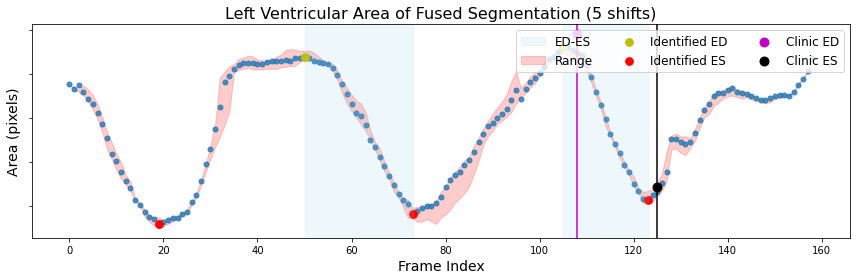

In [350]:
fts = 14
base_filename = None

fig, ax = plt.subplots(1, figsize=(12, 4))

lv_sizes = np.sum(fused_segmentations, axis=(1, 2)).ravel()

first = True
for clip in clip_pairs:
    if first:
        ax.axvspan(clip[0], clip[1], alpha=0.15, color='skyblue', label="ED-ES")
        first=False
    else:
        ax.axvspan(clip[0], clip[1], alpha=0.15, color='skyblue')

ax.fill_between(np.arange(len(lv_sizes)), itr_val_lower_bound, itr_val_upper_bound, color='r', alpha=0.2, label="Range")

ax.scatter(np.arange(len(lv_sizes)), lv_sizes, s=25, alpha=0.8)
        
ax.scatter(diastole, size[diastole], s=60, c='y', label="Identified ED")
ax.scatter(systole, size[systole], s=60, c='r', label="Identified ES")

ax.set_title("Left Ventricular Area of Fused Segmentation ({:d} shifts)"
             .format(len(all_interpolated_segmentations)), fontsize=fts + 2)

ax.set_xlabel("Frame Index", fontsize=fts)
plt.ylabel("Area (pixels)", fontsize=fts)
ax.set_yticklabels([])

plt.scatter(ed_index, np.sum(ed_label), 
            s=80, color="m", label="Clinic ED")
plt.scatter(es_index, np.sum(es_label), 
            s=80, color="k", label="Clinic ES")

plt.axvline(ed_index, c='m')
plt.axvline(es_index, c='k')

plt.legend(fontsize=fts - 2, ncol=3, loc="upper right")
plt.tight_layout()

if base_filename:
    # User's responsibility to set the style before getting here.
    # Save the plot, use the provided filename.
    plt.savefig(base_filename+'_fused_sizes_putative_ED_ES.pdf', bbox_inches='tight')

    plt.savefig(base_filename+'_fused_sizes_putative_ED_ES.png', bbox_inches='tight',
                dpi=300, transparent=False);

    plt.savefig(base_filename+'_fused_sizes_putative_ED_ES_transp.png', bbox_inches='tight',
                dpi=300, transparent=True);

plt.show()